# Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm
from scipy.stats import fisher_exact
import random 

random.seed(416)
np.random.seed(416)

# Power Analysis

## Treatment Effect
We estimate a treatment effect from a laboratory study and then "discount" this effect, informed by how other misinformation effects decayed in the field vs the lab. 

- A laboratory experiment (Kaiser et al (2022)) asked users to imagine that somebody the participant followed posted misinformation. Then the study asked participant's to rate their intentions to unfollow that individual on a scale of 1-6, with 1 being unfollowing "does not at all apply" and 6 being "does fully apply". Summing the percentage of respondents who answered 4-6 is a rough measure of the percentage of respondent's who would be more likely than not to unfollow. That sum is ~19%.

- One study (Lin et al 2024) compared the effect size of accuracy nudges in the lab to the effect size of accurarcy nudges when used in a digital ad experiment similar to ours. We use this ratio to inform how much to discount Kaiser et al. (2022). From page 11, we use the lower bound of the ad efficacy (2.6%) and the upper bound of the lab estimate (10%) to arrive at a base discount factor of (1 - 2.6/10) 74%. Doing so would yield 26% of 19%  = 5%. So we sample treatment unfollowing proportions centered at 5% (which is the base case)

## Control Rate
- Ashkinaze et al (2024) looked at the unfollowing rate of health misinformation spreaders and found it was 0.52% per month (95% CI = [0.46%, 0.58%]) so we take the upper bound of this CI as the monthly rate

- We then assume the effective control unfollowing rate would be monthly_rate / months = (monthly_rate / (n_days/30))

## Compliance
- We assume various rates of how many eligible treatment users actually comply [0.1, 0.2 0.3]. This rate represents the number of users we assigned to treatment who actually view the ad. This number is likely lower than 100% for a number of reasons: Uneligible to be targeted, not on Twitter at the time, did not get served ad. 

In [27]:
def process_task(control_prop, treatment_prop, n_days, N, treat_eligible, n_simulations, df):
    adj_control_prop = control_prop * (n_days / 30)
    power = estimate_power(df=df, N=N, 
                           control_prop=adj_control_prop, 
                           treatment_prop=treatment_prop, 
                           treat_eligible=treat_eligible, 
                           n_simulations=n_simulations, alpha=0.05)
    return {'treat_eligible':treat_eligible, 'control_prop': control_prop, 'treatment_prop': treatment_prop, 'n_days': n_days, 'N': N, 'power_itt': power['itt_power'], 'power_cace':power['cace_power']}


def run_power_analysis(params, df):
    tasks = [(control_prop, treatment_prop, n_days, N, treat_eligible, params['n_simulations'], df)
             for control_prop in params['control_prop']
             for treatment_prop in params['treatment_prop']
             for n_days in params['n_days']
             for treat_eligible in params['treat_eligible']
             for N in params['N_values']]
    
    results = Parallel(n_jobs=-1)(delayed(process_task)(*task) for task in tqdm(tasks, desc='Running simulations'))
    # results = [process_task(*task) for task in tasks]

    df_results = pd.DataFrame(results)
    return df_results

def estimate_power(df, N, control_prop, treatment_prop, treat_eligible, alpha=0.05, n_simulations=100):
    df_sample = df.sample(N, replace=False, random_state = np.random.randint(0,10000))
    N_control = df_sample[df_sample['treated'] == 0].shape[0]
    N_treatment = df_sample[df_sample['treated'] == 1].shape[0]
    sig_itt = 0
    sig_cace = 0
    for i in range(n_simulations):
        res_dict = difference_in_proportions_test(N_control, N_treatment, treat_eligible,  control_prop, treatment_prop, alpha)
        itt_res, cace_res = res_dict['itt'], res_dict['cace']
        if itt_res:
            sig_itt +=1
        if cace_res:
            sig_cace +=1

    power = {'itt_power':sig_itt/n_simulations, "cace_power":sig_cace/n_simulations}
    return power

def difference_in_proportions_test(N_control, N_treatment, treat_eligible, control_prop, treatment_prop, alpha=0.05):

    # Only `treat_eligible' prop complies 
    n_treatment_compliers = int(N_treatment*treat_eligible)
    n_treatment_noncompliers = N_treatment - n_treatment_compliers
    
    # Let us assume noncompliers had same unfollowing rate as control 
    control_outcomes = np.random.binomial(1, control_prop, size=N_control)
    treatment_complier_outcomes = np.random.binomial(1, treatment_prop, size=n_treatment_compliers) # CACE
    treatment_noncomplier_outcomes = np.random.binomial(1, control_prop, size=n_treatment_noncompliers) # Control rate

    
    # Get success of treated (compliers and noncompliers) and control
    success_control =  max(control_outcomes.sum(),1)
    success_treatment_compliers = max(np.sum(treatment_complier_outcomes),1)
    success_treatment_noncompliers = max(np.sum(treatment_noncomplier_outcomes),1)
    success_treatment = success_treatment_compliers+success_treatment_noncompliers

    # Also calculcate "failures" as outcomes where success did not occur, used for 
    # 2x2 table
    failure_control = N_control - success_control
    failure_treatment_compliers = n_treatment_compliers - success_treatment_compliers
    failure_treatment_noncompliers = n_treatment_noncompliers-success_treatment_noncompliers
    failure_treatment = N_treatment - success_treatment

    # ITT uses total treated users as the denominator 
    table = np.array([[success_treatment, success_control], [failure_treatment, failure_control]])
    itt_oddsr, itt_p_value = fisher_exact(table, alternative='greater')
    itt_res = (itt_p_value <= alpha)
   
    # CACE is just based on compliers   
    table = np.array([[success_treatment_compliers, success_control], [failure_treatment_compliers, failure_control]])
    cace_oddsr, cace_p_value = fisher_exact(table, alternative='greater')
    cace_res = (cace_p_value <= alpha)
    
    
    return {'itt':itt_res, 'cace':cace_res}


def make_graph(df_results):
    df_results['treatment_prop_label'] = df_results['treatment_prop'].apply(lambda x: f"{x:.3f}")
    for dv in ['power_itt', 'power_cace']:
        for n_days in df_results['n_days'].unique(): 
            for treat_eligible in df_results['treat_eligible'].unique():
                plt.figure(figsize=(10, 6))
                title = "Power Analysis Graph\n(Days = {}, DV = {}, Treat Eligible = {})".format(n_days, dv, treat_eligible)
                plt.title(title)
                sns.lineplot(data=df_results.query(f"n_days=={n_days} & treat_eligible=={treat_eligible}"), 
                             x="N", 
                             y=dv, 
                             hue="treatment_prop_label")
                plt.axhline(y=0.8, linestyle='dashed', color='red')  
                plt.axhline(y=0.9, linestyle='dashed', color='red')  

                plt.legend(title="Treatment Unfollow")
                plt.xlabel("Sample Size")
                plt.ylabel("Power")
                sns.despine()
                plt.savefig(f"{dv}_{treat_eligible}.png", dpi=400)
                plt.show()
     

def find_required_n(df_results):
    for dv in ['power_itt', 'power_cace']:
        for treat_eligible in df_results['treat_eligible'].unique():
            print("PRINTING RESULTS FOR MIN N AT 90% POWER FOR: {} and Treat Eligible = {}".format(dv, treat_eligible))
            df_filtered = df_results.query(f"treat_eligible=={treat_eligible}&{dv}>0.9")
            df_required_N = df_filtered.groupby('treatment_prop', as_index=False)['N'].min()
            df_required_N['treatment_prop_label'] = df_required_N['treatment_prop'].apply(lambda x: f"{x:.3f}")
            print(df_required_N)



df = pd.read_csv("treat_status_MINIMAL_FOLLOWERS_03.04.2024__17.11.03__START0_END-1.csv")

params = {
    'control_prop': [0.0058],
    'treatment_prop': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
    'N_values': np.linspace(2000, 500000, 1000, dtype=int),
    'n_days':[14],
    'n_simulations': 1000,
    "treat_eligible":[0.1, 0.2, 0.3]
}



# df_results = run_power_analysis(params, df)
# df_results.to_csv("power_analysis_results.csv")

# Analyze results

In [19]:
import math
pow = pd.read_csv("power_analysis_results.csv")
total_sims = len(pow)*1000 # 1000 simulations for each combo 
print("Total simulations (Millions)", total_sims/ 1e6)

Total simulations (Millions) 27.0


## Find required N

In [20]:
find_required_n(pow)

PRINTING RESULTS FOR MIN N AT 90% POWER FOR: power_itt and Treat Eligible = 0.1
   treatment_prop       N treatment_prop_label
0            0.01  295117                0.010
1            0.02   65807                0.020
2            0.03   30414                0.030
3            0.04   18450                0.040
4            0.05   12468                0.050
5            0.06    9477                0.060
6            0.07    7483                0.070
7            0.08    5987                0.080
8            0.09    5987                0.090
PRINTING RESULTS FOR MIN N AT 90% POWER FOR: power_itt and Treat Eligible = 0.2
   treatment_prop      N treatment_prop_label
0            0.01  85747                0.010
1            0.02  21441                0.020
2            0.03  10972                0.030
3            0.04   6984                0.040
4            0.05   4990                0.050
5            0.06   3993                0.060
6            0.07   2996                0.070
7 

In [26]:
import math
conservative_n = 295117
padding = 0.25
effective_n = math.ceil((1+padding)*conservative_n)
n_per = math.ceil(effective_n/5)
print("Effective N", effective_n, "N per", n_per)

Effective N 368897 N per 73780


## Raw curves

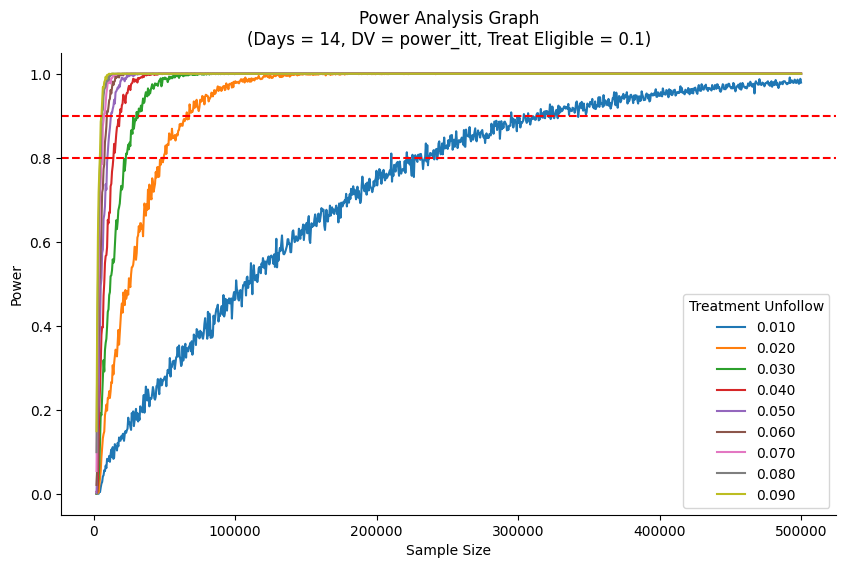

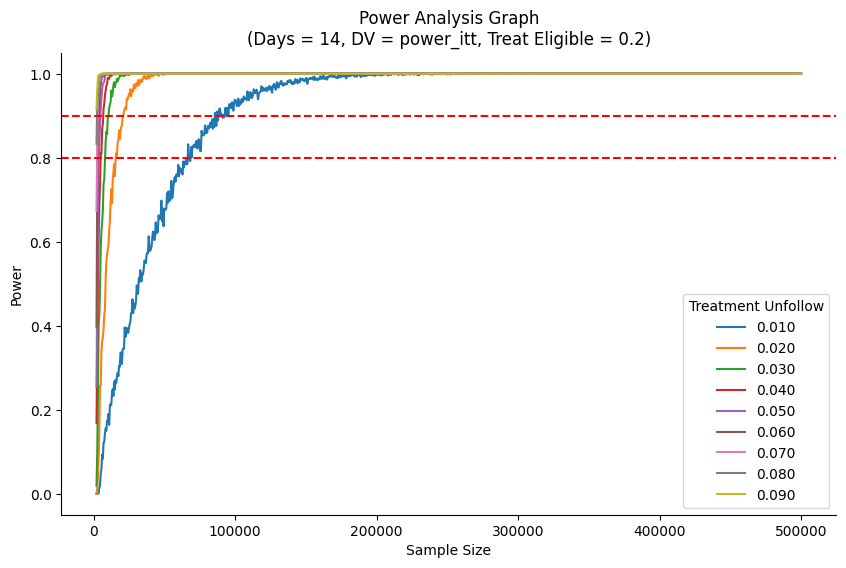

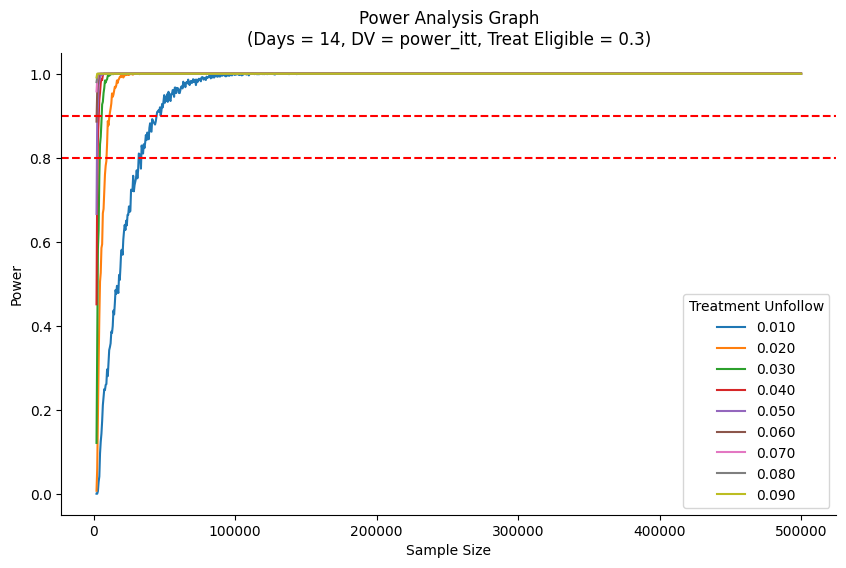

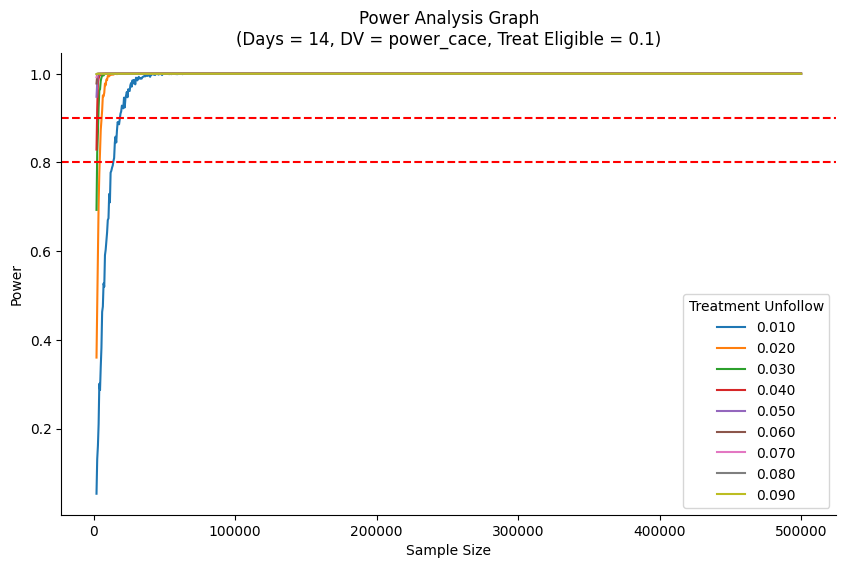

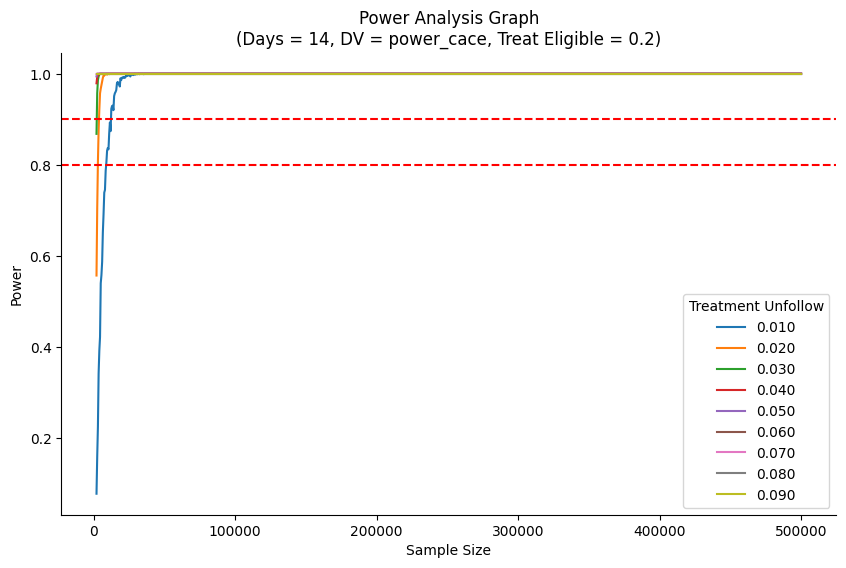

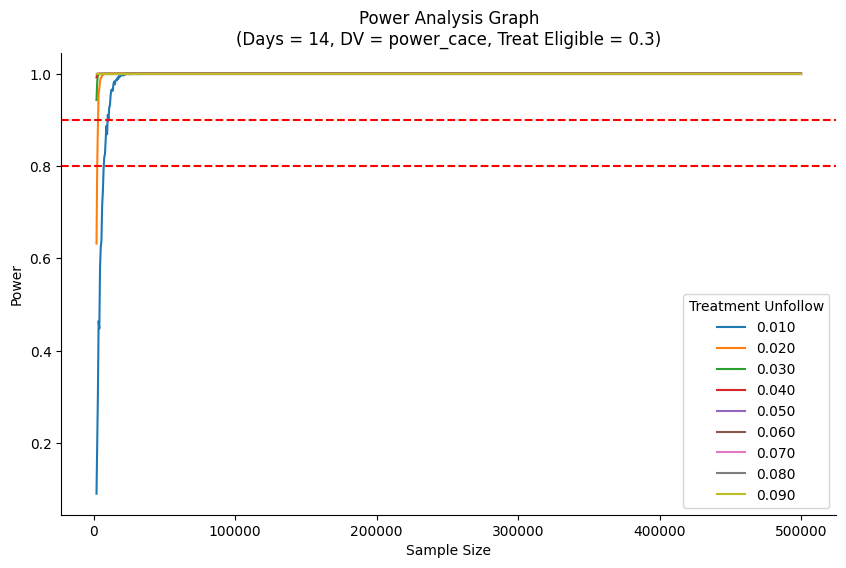

In [28]:
make_graph(pow)